<a href="https://colab.research.google.com/github/menna02/AI-ML/blob/main/Machine%20Learning/Flood_Prediction_using_Boosting_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'playground-series-s4e5:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F73278%2F8121328%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240530%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240530T042643Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D42da53be655b3307bb4a676cc11f95f2b2a438376f5b71f74a1fd3f2a940c10c6bfcf9e9ede1db3c774b9374e34b8a25ea05acd161fd2535fe6bb29ebca84fb1567c0c0d371e2cafcd5423f8a64d64b252dca4025c2def33089bdca760ee92bdc415c1c4b6ad11f370c0f78dbb00c17a523f9ce134aff11077275e5ba9cbecd7c72500b28f0fbb6462b5030ebc22f9628f4da932621fe13f53d582bd2660cded6b36801989ddf15f9f93a21901dee5889bccd90893a70db5ed4d20473b614f76932c1a973582564abde07804156f199a9611a005e71915fecb2a996a064151253809080f841a3b116a431294ded83501ebcfe408474136e63f39e37a7393322a'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 29311374 bytes downloaded
Downloaded and uncompressed: playground-series-s4e5
Data source import complete.


# Import Needed Libraries

In [ ]:
# !pip install pycaret

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
import warnings

# Ignore all future warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Read The Dataset

In [ ]:
data = pd.read_csv('/kaggle/input/playground-series-s4e5/train.csv')
train = data.copy()
train.head(5)

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,0,5,8,5,8,6,4,4,3,3,...,5,3,3,5,4,7,5,7,3,0.445
1,1,6,7,4,4,8,8,3,5,4,...,7,2,0,3,5,3,3,4,3,0.450
2,2,6,5,6,7,3,7,1,5,4,...,7,3,7,5,6,8,2,3,3,0.530
3,3,3,4,6,5,4,8,4,7,6,...,2,4,7,4,4,6,5,7,5,0.535
4,4,5,3,2,6,4,4,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415


# EDA and Preprocessing

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117957 entries, 0 to 1117956
Data columns (total 22 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   id                               1117957 non-null  int64  
 1   MonsoonIntensity                 1117957 non-null  int64  
 2   TopographyDrainage               1117957 non-null  int64  
 3   RiverManagement                  1117957 non-null  int64  
 4   Deforestation                    1117957 non-null  int64  
 5   Urbanization                     1117957 non-null  int64  
 6   ClimateChange                    1117957 non-null  int64  
 7   DamsQuality                      1117957 non-null  int64  
 8   Siltation                        1117957 non-null  int64  
 9   AgriculturalPractices            1117957 non-null  int64  
 10  Encroachments                    1117957 non-null  int64  
 11  IneffectiveDisasterPreparedness  1117957 non-null 

In [ ]:
train.isna().sum()

id                                 0
MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64

* the data has no Nans
* there are no object columns, so no need for encoding

In [ ]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1117957.0,558978.000000,322726.531784,0.000,279489.00,558978.000,838467.00,1117956.000
MonsoonIntensity,1117957.0,4.921450,2.056387,0.000,3.00,5.000,6.00,16.000
TopographyDrainage,1117957.0,4.926671,2.093879,0.000,3.00,5.000,6.00,18.000
RiverManagement,1117957.0,4.955322,2.072186,0.000,4.00,5.000,6.00,16.000
Deforestation,1117957.0,4.942240,2.051689,0.000,4.00,5.000,6.00,17.000
Urbanization,1117957.0,4.942517,2.083391,0.000,3.00,5.000,6.00,17.000
ClimateChange,1117957.0,4.934093,2.057742,0.000,3.00,5.000,6.00,17.000
DamsQuality,1117957.0,4.955878,2.083063,0.000,4.00,5.000,6.00,16.000
Siltation,1117957.0,4.927791,2.065992,0.000,3.00,5.000,6.00,16.000
AgriculturalPractices,1117957.0,4.942619,2.068545,0.000,3.00,5.000,6.00,16.000


* The features kinda have the same distribution

### Data Visualization

#### Feature 1: MonsoonIntensity

A monsoon is a seasonal change in the direction of the prevailing, or strongest, winds of a region. Monsoons cause wet and dry seasons throughout much of the tropics.

In [ ]:
train['MonsoonIntensity'].describe()

count    1.117957e+06
mean     4.921450e+00
std      2.056387e+00
min      0.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      6.000000e+00
max      1.600000e+01
Name: MonsoonIntensity, dtype: float64

In [ ]:
train['MonsoonIntensity'].value_counts().sort_values()

MonsoonIntensity
16        42
15       169
14       391
13       729
12      2062
0       5431
11      5851
10     14040
1      28946
9      33515
8      65954
2      86683
7     109210
3     160574
6     169080
4     214344
5     220936
Name: count, dtype: int64

* The feature is categorical with range(0,16)

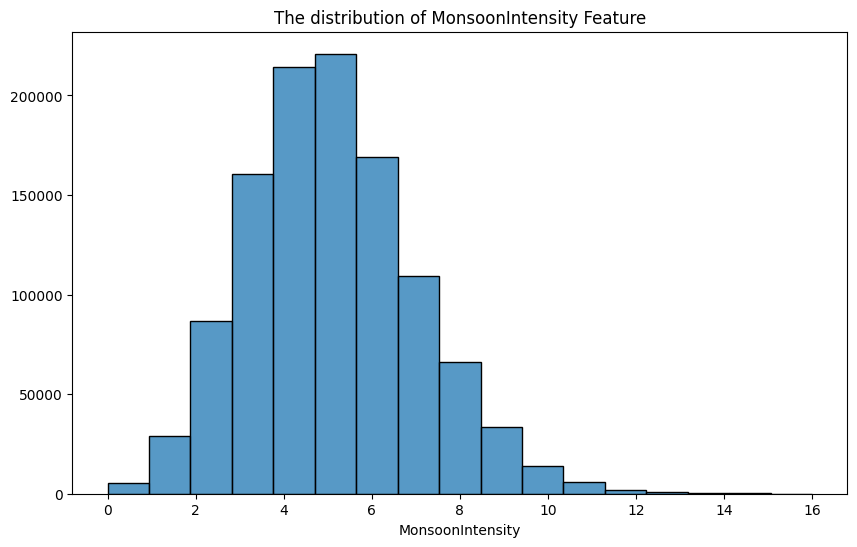

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(x=train['MonsoonIntensity'], bins=17)
plt.title("The distribution of MonsoonIntensity Feature")
plt.ylabel("")
plt.show()

* The '16' Category could be considered as an outlier because of its minority when compared to '5' category

In [ ]:
train = train.drop((train[train['MonsoonIntensity']==16]).index, axis=0)

In [ ]:
train['MonsoonIntensity'].describe()

count    1.117915e+06
mean     4.921034e+00
std      2.055304e+00
min      0.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      6.000000e+00
max      1.500000e+01
Name: MonsoonIntensity, dtype: float64

#### Feature 2 : TopographyDrainage

Drainage pattern is the pattern formed by the streams, rivers, and lakes in a particular drainage area. They are governed by the topography of the land

In [ ]:
train['TopographyDrainage'].describe()

count    1.117915e+06
mean     4.926688e+00
std      2.093874e+00
min      0.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      6.000000e+00
max      1.800000e+01
Name: TopographyDrainage, dtype: float64

In [ ]:
train['TopographyDrainage'].value_counts().sort_values()

TopographyDrainage
18         3
17        10
16        42
15       106
14       333
13       705
12      2199
0       5541
11      6177
10     15523
1      29418
9      37544
8      71997
2      90054
7     102676
6     158999
3     161982
4     213360
5     221246
Name: count, dtype: int64

* The feature is categorical with range(0,18)

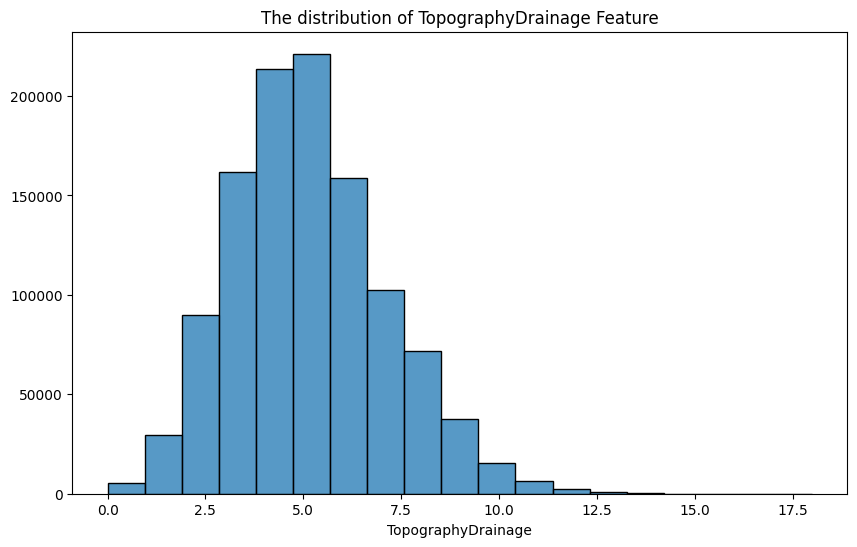

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(x=train['TopographyDrainage'], bins=19)
plt.title("The distribution of TopographyDrainage Feature")
plt.ylabel("")
plt.show()

* The '18','16','17'  Category could be considered as an outlier because of its minority when compared to '5' category

In [ ]:
train = train.drop((train[train['TopographyDrainage']==16]).index, axis=0)
train = train.drop((train[train['TopographyDrainage']==17]).index, axis=0)
train = train.drop((train[train['TopographyDrainage']==18]).index, axis=0)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1117860 entries, 0 to 1117956
Data columns (total 22 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   id                               1117860 non-null  int64  
 1   MonsoonIntensity                 1117860 non-null  int64  
 2   TopographyDrainage               1117860 non-null  int64  
 3   RiverManagement                  1117860 non-null  int64  
 4   Deforestation                    1117860 non-null  int64  
 5   Urbanization                     1117860 non-null  int64  
 6   ClimateChange                    1117860 non-null  int64  
 7   DamsQuality                      1117860 non-null  int64  
 8   Siltation                        1117860 non-null  int64  
 9   AgriculturalPractices            1117860 non-null  int64  
 10  Encroachments                    1117860 non-null  int64  
 11  IneffectiveDisasterPreparedness  1117860 non-null  int6

#### Feature 3 : RiverManagement

River Management is defined as the management of water resources of a basin as part of the natural ecosystem and in relation to their socio-economic setting.

In [ ]:
train['RiverManagement'].describe()

count    1.117860e+06
mean     4.955313e+00
std      2.072169e+00
min      0.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      6.000000e+00
max      1.600000e+01
Name: RiverManagement, dtype: float64

In [ ]:
train['RiverManagement'].value_counts().sort_values()

RiverManagement
16        43
15        92
14       297
13       715
12      2120
0       5407
11      5773
10     15168
1      28869
9      36227
8      71195
2      83772
7     108524
3     160032
6     167357
4     214065
5     218204
Name: count, dtype: int64

* The feature is categorical with range(0,16)

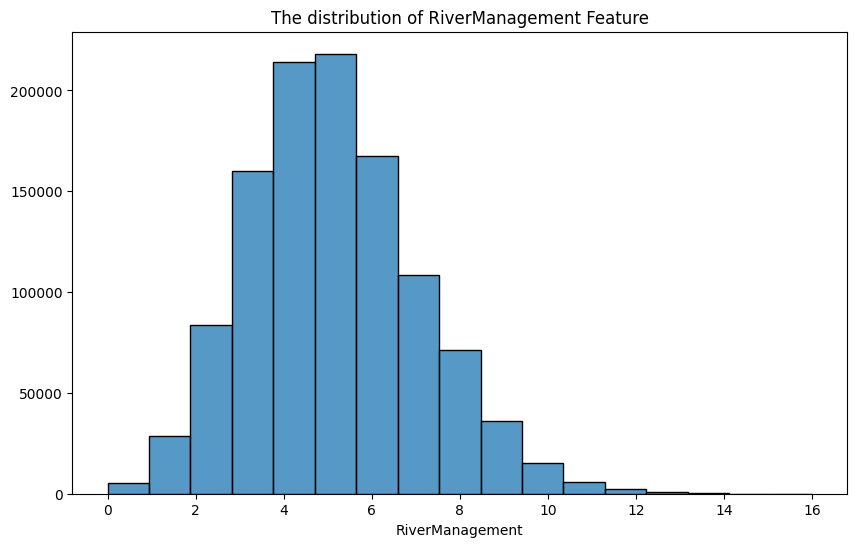

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(x=train['RiverManagement'], bins=17)
plt.title("The distribution of RiverManagement Feature")
plt.ylabel("")
plt.show()

* The '16','15'  Category could be considered as an outlier because of its minority when compared to '5' category

In [ ]:
train = train.drop((train[train['RiverManagement']==16]).index, axis=0)
train = train.drop((train[train['RiverManagement']==15]).index, axis=0)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1117725 entries, 0 to 1117956
Data columns (total 22 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   id                               1117725 non-null  int64  
 1   MonsoonIntensity                 1117725 non-null  int64  
 2   TopographyDrainage               1117725 non-null  int64  
 3   RiverManagement                  1117725 non-null  int64  
 4   Deforestation                    1117725 non-null  int64  
 5   Urbanization                     1117725 non-null  int64  
 6   ClimateChange                    1117725 non-null  int64  
 7   DamsQuality                      1117725 non-null  int64  
 8   Siltation                        1117725 non-null  int64  
 9   AgriculturalPractices            1117725 non-null  int64  
 10  Encroachments                    1117725 non-null  int64  
 11  IneffectiveDisasterPreparedness  1117725 non-null  int6

#### Feature 4 : Deforestation

Deforestation is the purposeful clearing of forested land

In [ ]:
train['Deforestation'].describe()

count    1.117725e+06
mean     4.942298e+00
std      2.051647e+00
min      0.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      6.000000e+00
max      1.700000e+01
Name: Deforestation, dtype: float64

In [ ]:
train['Deforestation'].value_counts().sort_values()

Deforestation
17         6
16        35
15       115
14       293
13       705
12      2079
0       5324
11      5704
10     13964
1      26869
9      34580
8      69223
2      85928
7     109021
3     157294
6     169148
5     217750
4     219687
Name: count, dtype: int64

* The feature is categorical with range(0,17)

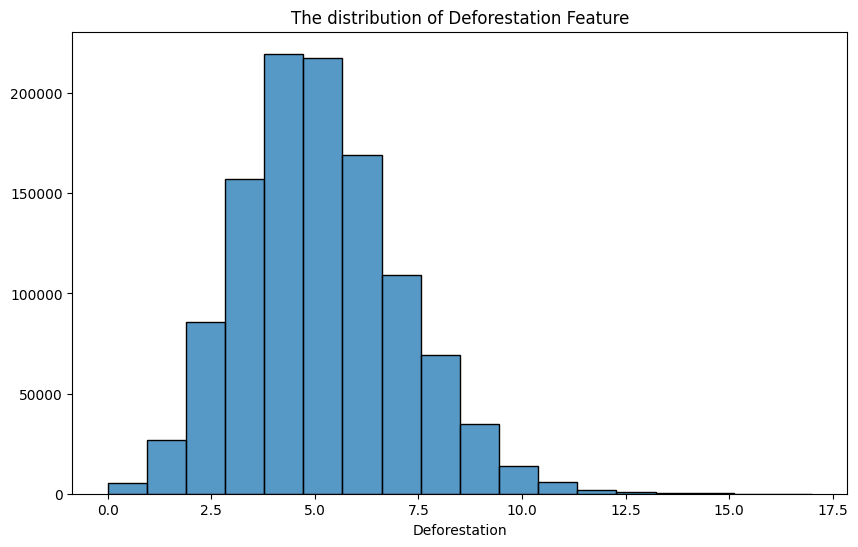

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(x=train['Deforestation'], bins=18)
plt.title("The distribution of Deforestation Feature")
plt.ylabel("")
plt.show()

* The '16','17'  Category could be considered as an outlier because of its minority when compared to '5' category

In [ ]:
train = train.drop((train[train['Deforestation']==16]).index, axis=0)
train = train.drop((train[train['Deforestation']==17]).index, axis=0)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1117684 entries, 0 to 1117956
Data columns (total 22 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   id                               1117684 non-null  int64  
 1   MonsoonIntensity                 1117684 non-null  int64  
 2   TopographyDrainage               1117684 non-null  int64  
 3   RiverManagement                  1117684 non-null  int64  
 4   Deforestation                    1117684 non-null  int64  
 5   Urbanization                     1117684 non-null  int64  
 6   ClimateChange                    1117684 non-null  int64  
 7   DamsQuality                      1117684 non-null  int64  
 8   Siltation                        1117684 non-null  int64  
 9   AgriculturalPractices            1117684 non-null  int64  
 10  Encroachments                    1117684 non-null  int64  
 11  IneffectiveDisasterPreparedness  1117684 non-null  int6

#### Feature 5 : Urbanization

Urbanization is the population shift from rural to urban areas

In [ ]:
train['Urbanization'].describe()

count    1.117684e+06
mean     4.942587e+00
std      2.083336e+00
min      0.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      6.000000e+00
max      1.700000e+01
Name: Urbanization, dtype: float64

In [ ]:
train['Urbanization'].value_counts().sort_values()

Urbanization
17         7
16        36
15       137
14       313
13       791
12      2210
0       5344
11      5688
10     15684
1      29661
9      36847
8      69280
2      86090
7     107671
3     162187
6     166658
4     212403
5     216677
Name: count, dtype: int64

* The feature is categorical with range(0,17)

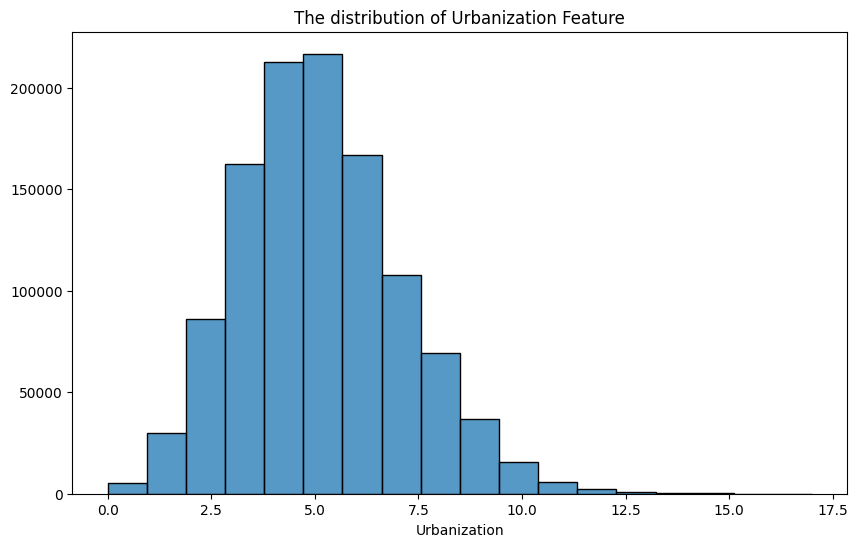

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(x=train['Urbanization'], bins=18)
plt.title("The distribution of Urbanization Feature")
plt.ylabel("")
plt.show()

* The '16','17'  Category could be considered as an outlier because of its minority when compared to '5' category

In [ ]:
train = train.drop((train[train['Urbanization']==16]).index, axis=0)
train = train.drop((train[train['Urbanization']==17]).index, axis=0)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1117641 entries, 0 to 1117956
Data columns (total 22 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   id                               1117641 non-null  int64  
 1   MonsoonIntensity                 1117641 non-null  int64  
 2   TopographyDrainage               1117641 non-null  int64  
 3   RiverManagement                  1117641 non-null  int64  
 4   Deforestation                    1117641 non-null  int64  
 5   Urbanization                     1117641 non-null  int64  
 6   ClimateChange                    1117641 non-null  int64  
 7   DamsQuality                      1117641 non-null  int64  
 8   Siltation                        1117641 non-null  int64  
 9   AgriculturalPractices            1117641 non-null  int64  
 10  Encroachments                    1117641 non-null  int64  
 11  IneffectiveDisasterPreparedness  1117641 non-null  int6

#### Feature 6 : ClimateChange

Climate change refers to long-term shifts in temperatures and weather patterns.

In [ ]:
train['ClimateChange'].describe()

count    1.117641e+06
mean     4.934167e+00
std      2.057654e+00
min      0.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      6.000000e+00
max      1.700000e+01
Name: ClimateChange, dtype: float64

In [ ]:
train['ClimateChange'].value_counts().sort_values()

ClimateChange
17         3
16        35
15        96
14       260
13       727
12      2063
0       5343
11      5514
10     14453
1      27303
9      34673
8      69158
2      88128
7     107774
3     159687
6     169276
4     214210
5     218938
Name: count, dtype: int64

* The feature is categorical with range(0,17)

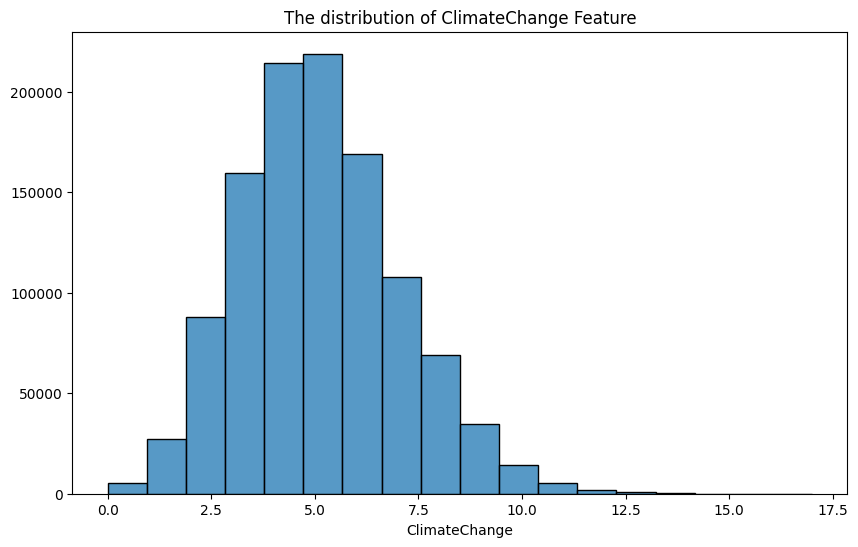

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(x=train['ClimateChange'], bins=18)
plt.title("The distribution of ClimateChange Feature")
plt.ylabel("")
plt.show()

* The '16','17', '15'  Category could be considered as an outlier because of its minority when compared to '5' category

In [ ]:
train = train.drop((train[train['ClimateChange']==16]).index, axis=0)
train = train.drop((train[train['ClimateChange']==17]).index, axis=0)
train = train.drop((train[train['ClimateChange']==15]).index, axis=0)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1117507 entries, 0 to 1117956
Data columns (total 22 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   id                               1117507 non-null  int64  
 1   MonsoonIntensity                 1117507 non-null  int64  
 2   TopographyDrainage               1117507 non-null  int64  
 3   RiverManagement                  1117507 non-null  int64  
 4   Deforestation                    1117507 non-null  int64  
 5   Urbanization                     1117507 non-null  int64  
 6   ClimateChange                    1117507 non-null  int64  
 7   DamsQuality                      1117507 non-null  int64  
 8   Siltation                        1117507 non-null  int64  
 9   AgriculturalPractices            1117507 non-null  int64  
 10  Encroachments                    1117507 non-null  int64  
 11  IneffectiveDisasterPreparedness  1117507 non-null  int6

#### The rest of the features

In [ ]:
# Drop the ID feature
train = train.drop(columns=['id'], axis=1)

In [ ]:
# Dropping the outlier values from all features
for i in train.columns:
  if train[i].describe()['max']>15:
    for c in range(16,int(train[i].describe()['max'])):
      # print(train[train[i]==c])
      train = train.drop((train[train[i]==c]).index, axis=0)
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1117257 entries, 0 to 1117956
Data columns (total 21 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   MonsoonIntensity                 1117257 non-null  int64  
 1   TopographyDrainage               1117257 non-null  int64  
 2   RiverManagement                  1117257 non-null  int64  
 3   Deforestation                    1117257 non-null  int64  
 4   Urbanization                     1117257 non-null  int64  
 5   ClimateChange                    1117257 non-null  int64  
 6   DamsQuality                      1117257 non-null  int64  
 7   Siltation                        1117257 non-null  int64  
 8   AgriculturalPractices            1117257 non-null  int64  
 9   Encroachments                    1117257 non-null  int64  
 10  IneffectiveDisasterPreparedness  1117257 non-null  int64  
 11  DrainageSystems                  1117257 non-null  int6

## Data Prepration

#### X, y Splitting

In [ ]:
X = train.iloc[:,:-1]
y = train.iloc[:,-1]
print('X shape',X.shape)
print('y shape',y.shape)


X shape (1117257, 20)
y shape (1117257,)


#### Train Test Split

In [ ]:
X_train,X_test, y_train,y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print('X_train shape',X_train.shape)
print('y_train shape',y_train.shape)
print('X_test shape',X_test.shape)
print('y_test shape',y_test.shape)

X_train shape (1005531, 20)
y_train shape (1005531,)
X_test shape (111726, 20)
y_test shape (111726,)


#### Train Data Scaling
* The data ranges are not large, so I will use MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Implementing different Models

##### 1- LGBM Regressor
[Documentation Link](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html)

In [ ]:
lgbm = LGBMRegressor(learning_rate=0.1, n_estimators=1000, random_state=42)
lgbm.fit(X_train, y_train)
print("Train Accuracy:",lgbm.score(X_train, y_train))
y_pred = lgbm.predict(X_test)
print("Test Accuracy:",lgbm.score(X_train, y_train))
print("Mean Squared Error:",mean_squared_error(y_test, y_pred))
print("R2 Score:",r2_score(y_test, y_pred))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.189278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 329
[LightGBM] [Info] Number of data points in the train set: 1005531, number of used features: 20
[LightGBM] [Info] Start training from score 0.504460
Train Accuracy: 0.8479305399138604
Test Accuracy: 0.8479305399138604
Mean Squared Error: 0.00042201083731053255
R2 Score: 0.8381729291148131


##### 2- Extra Gradiant Boost Regressor
[Documentation Link](https://xgboost.readthedocs.io/en/stable/parameter.html)

In [ ]:
xgbr = XGBRegressor(n_estimators=3000, random_state=42, learning_rate=0.01)
xgbr.fit(X_train, y_train)
print("Train Accuracy:",xgbr.score(X_train, y_train))
y_pred = xgbr.predict(X_test)
print("Test Accuracy:",xgbr.score(X_test, y_test))
print("Mean Squared Error:",mean_squared_error(y_test, y_pred))
print("R2 Score:",r2_score(y_test, y_pred))

Train Accuracy: 0.8514944918537246
Test Accuracy: 0.8402455595658953
Mean Squared Error: 0.000416605854650264
R2 Score: 0.8402455595658953


##### 3- Cat Boost Regressor
[Documentation Link](https://catboost.ai/en/docs/concepts/python-reference_catboostregressor)

In [ ]:
catboost = CatBoostRegressor(learning_rate=0.1,random_seed=42, n_estimators=1000)
catboost.fit(X_train, y_train)


0:	learn: 0.0502833	total: 253ms	remaining: 4m 13s
1:	learn: 0.0495603	total: 444ms	remaining: 3m 41s
2:	learn: 0.0488471	total: 626ms	remaining: 3m 27s
3:	learn: 0.0481835	total: 818ms	remaining: 3m 23s
4:	learn: 0.0475537	total: 995ms	remaining: 3m 18s
5:	learn: 0.0469251	total: 1.2s	remaining: 3m 19s
6:	learn: 0.0463236	total: 1.53s	remaining: 3m 36s
7:	learn: 0.0457452	total: 1.82s	remaining: 3m 45s
8:	learn: 0.0451732	total: 2.15s	remaining: 3m 56s
9:	learn: 0.0446069	total: 2.47s	remaining: 4m 5s
10:	learn: 0.0441013	total: 2.75s	remaining: 4m 7s
11:	learn: 0.0436039	total: 3.05s	remaining: 4m 11s
12:	learn: 0.0431111	total: 3.34s	remaining: 4m 13s
13:	learn: 0.0426361	total: 3.61s	remaining: 4m 14s
14:	learn: 0.0421637	total: 3.89s	remaining: 4m 15s
15:	learn: 0.0416979	total: 4.18s	remaining: 4m 17s
16:	learn: 0.0412416	total: 4.42s	remaining: 4m 15s
17:	learn: 0.0408208	total: 4.58s	remaining: 4m 9s
18:	learn: 0.0404049	total: 4.74s	remaining: 4m 4s
19:	learn: 0.0399962	total:

In [ ]:
print("Train Accuracy of CatBoost:",catboost.score(X_train, y_train))
y_pred = catboost.predict(X_test)
print("Test Accuracy of CatBoost:",catboost.score(X_test, y_test))
print("Mean Squared Error:",mean_squared_error(y_test, y_pred))
print("R2 Score of CatBoost:",r2_score(y_test, y_pred))

Train Accuracy of CatBoost: 0.8485817588881682
Test Accuracy of CatBoost: 0.8454950255051435
Mean Squared Error: 0.0004029163557034096
R2 Score of CatBoost: 0.8454950255051435


**The best R2 till NOW**

This is why I will use it to predict the test Data

# Importing the test Data to prepare the submision file

In [ ]:
test = pd.read_csv('/kaggle/input/playground-series-s4e5/test.csv')
test.head(5)

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors
0,1117957,4,6,3,5,6,7,8,7,8,...,8,5,7,5,6,3,6,4,4,5
1,1117958,4,4,2,9,5,5,4,7,5,...,2,4,7,4,5,1,7,4,4,3
2,1117959,1,3,6,5,7,2,4,6,4,...,7,9,2,5,5,2,3,6,8,3
3,1117960,2,4,4,6,4,5,4,3,4,...,7,8,4,6,7,6,4,2,4,4
4,1117961,6,3,2,4,6,4,5,5,3,...,4,3,2,6,4,6,8,4,5,5


### Applying this same scaling to the test data


In [ ]:
scaler = MinMaxScaler()
test_scaled = scaler.fit_transform(test.iloc[:,1:])
test_scaled

array([[0.25      , 0.35294118, 0.1875    , ..., 0.18181818, 0.25      ,
        0.3125    ],
       [0.25      , 0.23529412, 0.125     , ..., 0.18181818, 0.25      ,
        0.1875    ],
       [0.0625    , 0.17647059, 0.375     , ..., 0.27272727, 0.5       ,
        0.1875    ],
       ...,
       [0.3125    , 0.41176471, 0.5625    , ..., 0.22727273, 0.3125    ,
        0.25      ],
       [0.25      , 0.41176471, 0.375     , ..., 0.31818182, 0.3125    ,
        0.3125    ],
       [0.25      , 0.11764706, 0.3125    , ..., 0.36363636, 0.375     ,
        0.1875    ]])

In [ ]:
y_pred = catboost.predict(test_scaled)

In [ ]:
submission = pd.DataFrame({'id': test['id'], 'FloodProbability': y_pred}, columns=['id', 'FloodProbability'])

submission.to_csv('submission.csv', index=False)